# 01 - Preprocesamiento para Regresión de RSAM

In [1]:
from pathlib import Path
import yaml
import obspy
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Librerías cargadas")

Librerías cargadas


In [ ]:

PROJECT_ROOT = Path.cwd().parent

with open(PROJECT_ROOT / "config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

UNLABELED_DATA = Path(cfg["paths"]["unlabeled_data"])
FIGURES_DIR = PROJECT_ROOT / cfg["paths"]["figures_output"]
TABLES_DIR = PROJECT_ROOT / cfg["paths"]["tables_output"]
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

FIGURES_DIR.mkdir(exist_ok=True, parents=True)
TABLES_DIR.mkdir(exist_ok=True, parents=True)
PROCESSED_DIR.mkdir(exist_ok=True, parents=True)

print("PROJECT_ROOT  :", PROJECT_ROOT)
print("UNLABELED_DATA:", UNLABELED_DATA)
print("PROCESSED_DIR :", PROCESSED_DIR)

PROJECT_ROOT  : c:\Users\nicol\Documents\AAST_PJ\AAST_PJ
UNLABELED_DATA: E:\Lascar_2018_2024\Pms
PROCESSED_DIR : c:\Users\nicol\Documents\AAST_PJ\AAST_PJ\data\processed


In [ ]:





STATION = "LC01"
CHANNEL = "HHZ"  
YEARS = [2023]   


SAMPLING_RATE = 100  


RSAM_WINDOW_SECONDS = 600  
DOWNSAMPLE_FACTOR = 5      


RSAM_PER_HOUR = 3600 // RSAM_WINDOW_SECONDS  





WINDOW_CONFIGS = {
    'short': {
        'input_hours': 12,
        'output_hours': 3,
        'description': 'Corto plazo (12h -> 3h)'
    },
    'medium': {
        'input_hours': 24,
        'output_hours': 6,
        'description': 'Medio plazo (24h -> 6h)'
    },
    'long': {
        'input_hours': 48,
        'output_hours': 12,
        'description': 'Largo plazo (48h -> 12h)'
    }
}


for name, config in WINDOW_CONFIGS.items():
    config['input_steps'] = config['input_hours'] * RSAM_PER_HOUR
    config['output_steps'] = config['output_hours'] * RSAM_PER_HOUR

print("Configuración general:")
print(f"  Estación: {STATION}, Canal: {CHANNEL}")
print(f"  Años: {YEARS}")
print(f"  Frecuencia original: {SAMPLING_RATE} Hz")
print(f"  Factor de decimación: {DOWNSAMPLE_FACTOR} ({SAMPLING_RATE}Hz -> {SAMPLING_RATE//DOWNSAMPLE_FACTOR}Hz)")
print(f"  RSAM cada: {RSAM_WINDOW_SECONDS//60} minutos")
print(f"  Valores RSAM por hora: {RSAM_PER_HOUR}")

print(f"\nConfiguraciones de ventanas:")
print("-" * 60)
for name, config in WINDOW_CONFIGS.items():
    print(f"  {name:8s}: {config['input_hours']:2d}h input ({config['input_steps']:3d} pts) -> "
          f"{config['output_hours']:2d}h output ({config['output_steps']:2d} pts)")

Configuración general:
  Estación: LC01, Canal: HHZ
  Años: [2023]
  Frecuencia original: 100 Hz
  Factor de decimación: 5 (100Hz -> 20Hz)
  RSAM cada: 10 minutos
  Valores RSAM por hora: 6

Configuraciones de ventanas:
------------------------------------------------------------
  short   : 12h input ( 72 pts) ->  3h output (18 pts)
  medium  : 24h input (144 pts) ->  6h output (36 pts)
  long    : 48h input (288 pts) -> 12h output (72 pts)


## 1. Identificar Archivos Disponibles

In [ ]:

files = [p.name for p in UNLABELED_DATA.rglob("*") if p.is_file()]

records = []
for f in files:
    parts = f.split(".")
    if len(parts) == 6:
        net, sta, loc, chan, year, doy = parts
        records.append({
            "network": net,
            "station": sta,
            "location": loc,
            "channel": chan,
            "year": int(year),
            "doy": int(doy),
            "filename": f
        })

df_files = pd.DataFrame(records)


df_subset = df_files[
    (df_files["station"] == STATION) &
    (df_files["channel"] == CHANNEL) &
    (df_files["year"].isin(YEARS))
].sort_values(["year", "doy"]).reset_index(drop=True)

print(f"Archivos encontrados: {len(df_subset)}")
print(f"\nResumen por año:")
print(df_subset.groupby("year").size())

Archivos encontrados: 365

Resumen por año:
year
2023    365
dtype: int64


## 2. Calcular RSAM

In [5]:
def calculate_rsam_from_trace(trace, window_seconds=RSAM_WINDOW_SECONDS):
    """
    Calcula RSAM para un trace de ObsPy.
    RSAM = Mean Absolute Amplitude
    """
    fs = trace.stats.sampling_rate
    data = trace.data
    start_time = trace.stats.starttime
    
    window_samples = int(window_seconds * fs)
    n_windows = len(data) // window_samples
    
    timestamps = []
    rsam_values = []
    
    for i in range(n_windows):
        start_idx = i * window_samples
        end_idx = start_idx + window_samples
        
        window_data = data[start_idx:end_idx]
        rsam = np.mean(np.abs(window_data))
        
        window_time = start_time + (i * window_seconds)
        
        timestamps.append(window_time.datetime)
        rsam_values.append(rsam)
    
    return np.array(timestamps), np.array(rsam_values, dtype=np.float32)

print("Función RSAM definida")

Función RSAM definida


In [ ]:

print(f"Procesando {len(df_subset)} archivos...\n")

all_timestamps = []
all_rsam = []
files_processed = 0
files_error = 0

for idx, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc="Calculando RSAM"):
    file_path = UNLABELED_DATA / row["filename"]
    
    try:
        st = obspy.read(str(file_path))
        
        
        actual_fs = st[0].stats.sampling_rate
        if files_processed == 0:
            print(f"\nFrecuencia de muestreo detectada: {actual_fs} Hz")
        
        
        if actual_fs >= SAMPLING_RATE:
            decimate_factor = int(actual_fs / (SAMPLING_RATE / DOWNSAMPLE_FACTOR))
            if decimate_factor > 1:
                st.decimate(factor=decimate_factor, no_filter=False)
        
        for tr in st:
            ts, rsam = calculate_rsam_from_trace(tr, RSAM_WINDOW_SECONDS)
            all_timestamps.extend(ts)
            all_rsam.extend(rsam)
        
        files_processed += 1
        
        if files_processed % 50 == 0:
            gc.collect()
            
    except Exception as e:
        files_error += 1
        if files_error <= 5:
            print(f"  Error en {row['filename']}: {e}")


df_rsam = pd.DataFrame({
    'datetime': all_timestamps,
    'rsam': all_rsam
})

df_rsam = df_rsam.sort_values('datetime').drop_duplicates(subset='datetime').reset_index(drop=True)

print(f"\n{'='*60}")
print(f"RSAM CALCULADO")
print(f"{'='*60}")
print(f"  Archivos procesados: {files_processed}")
print(f"  Archivos con error: {files_error}")
print(f"  Valores RSAM: {len(df_rsam):,}")
print(f"  Rango temporal: {df_rsam['datetime'].min()} -> {df_rsam['datetime'].max()}")

Procesando 365 archivos...



Calculando RSAM:   0%|          | 0/365 [00:00<?, ?it/s]


Frecuencia de muestreo detectada: 100.0 Hz


Calculando RSAM: 100%|██████████| 365/365 [01:14<00:00,  4.91it/s]


RSAM CALCULADO
  Archivos procesados: 365
  Archivos con error: 0
  Valores RSAM: 52,560
  Rango temporal: 2023-01-01 00:00:00 -> 2023-12-31 23:50:00


## 3. Exploración de la Serie RSAM

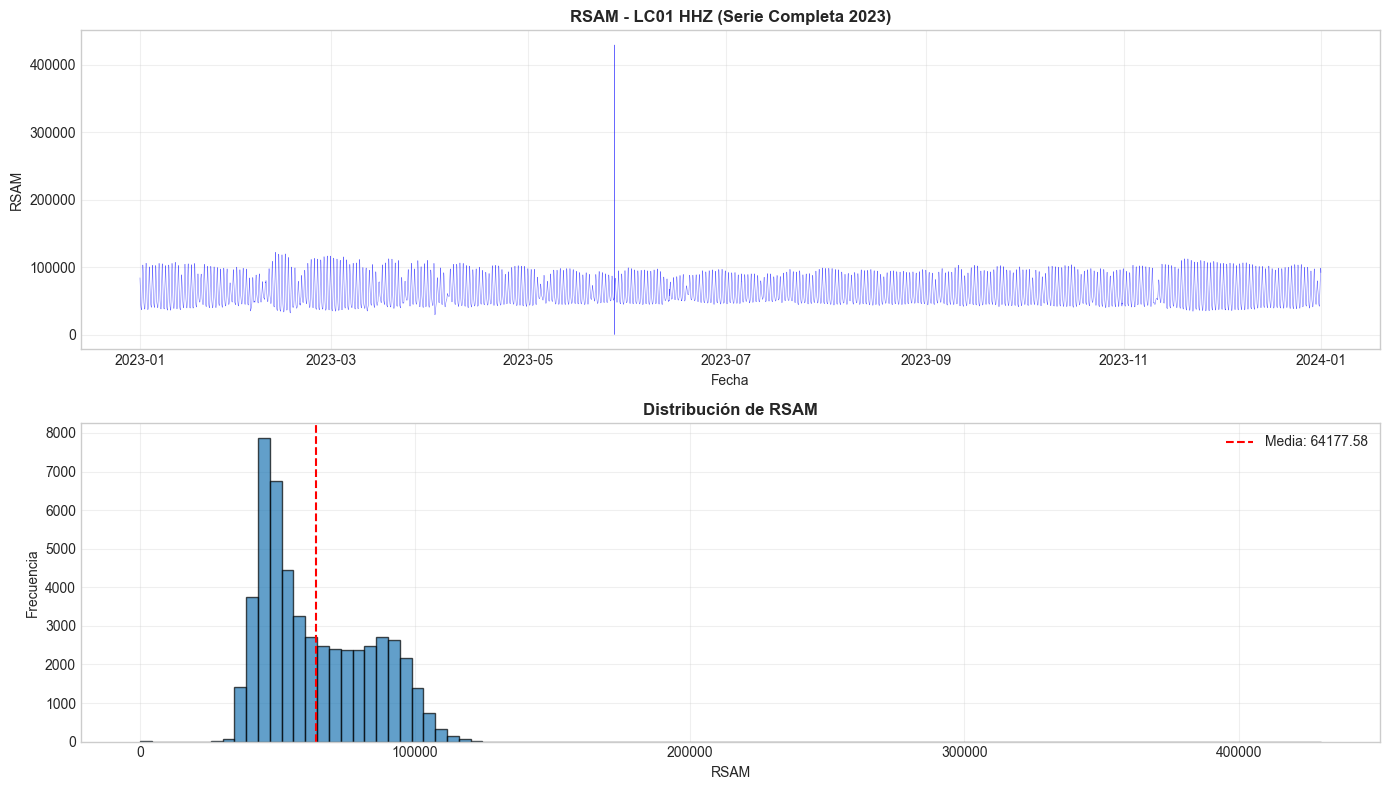

In [ ]:

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

ax1 = axes[0]
ax1.plot(df_rsam['datetime'], df_rsam['rsam'], 'b-', linewidth=0.3, alpha=0.7)
ax1.set_title(f'RSAM - {STATION} {CHANNEL} (Serie Completa 2023)', fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('RSAM')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.hist(df_rsam['rsam'], bins=100, edgecolor='black', alpha=0.7)
ax2.set_title('Distribución de RSAM', fontweight='bold')
ax2.set_xlabel('RSAM')
ax2.set_ylabel('Frecuencia')
ax2.axvline(df_rsam['rsam'].mean(), color='r', linestyle='--', label=f'Media: {df_rsam["rsam"].mean():.2f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'rsam_exploracion.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
print("="*60)
print("ESTADÍSTICAS RSAM")
print("="*60)
print(f"  Count:  {len(df_rsam):,}")
print(f"  Mean:   {df_rsam['rsam'].mean():.4f}")
print(f"  Std:    {df_rsam['rsam'].std():.4f}")
print(f"  Min:    {df_rsam['rsam'].min():.4f}")
print(f"  Max:    {df_rsam['rsam'].max():.4f}")

ESTADÍSTICAS RSAM
  Count:  52,560
  Mean:   64177.5781
  Std:    19713.2812
  Min:    0.0000
  Max:    429772.6875


## 4. Normalización

In [9]:
# Normalización Z-score
rsam_mean = df_rsam['rsam'].mean()
rsam_std = df_rsam['rsam'].std()

df_rsam['rsam_norm'] = (df_rsam['rsam'] - rsam_mean) / rsam_std

print(f"Normalización Z-score:")
print(f"  Media original: {rsam_mean:.4f}")
print(f"  Std original:   {rsam_std:.4f}")
print(f"  Media norm:     {df_rsam['rsam_norm'].mean():.6f}")
print(f"  Std norm:       {df_rsam['rsam_norm'].std():.6f}")

Normalización Z-score:
  Media original: 64177.5781
  Std original:   19713.2812
  Media norm:     -0.000000
  Std norm:       1.000000


## 5. Crear Ventanas para Predicción

In [10]:
def create_sequences(data, input_steps, output_steps, stride=1):
    X, y = [], []
    for i in range(0, len(data) - input_steps - output_steps + 1, stride):
        X.append(data[i:i + input_steps])
        y.append(data[i + input_steps:i + input_steps + output_steps])
    return np.array(X), np.array(y)


def temporal_split(X, y, train_ratio=0.70, val_ratio=0.15):
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    return {
        'X_train': X[:train_end],
        'X_val': X[train_end:val_end],
        'X_test': X[val_end:],
        'y_train': y[:train_end],
        'y_val': y[train_end:val_end],
        'y_test': y[val_end:]
    }

print("Funciones definidas")

Funciones definidas


In [11]:
rsam_values = df_rsam['rsam_norm'].values
datasets = {}

print("="*70)
print("CREANDO DATASETS PARA CADA CONFIGURACIÓN")
print("="*70)

for config_name, config in WINDOW_CONFIGS.items():
    print(f"\n{config_name.upper()}: {config['description']}")
    print("-" * 50)
    
    X, y = create_sequences(
        rsam_values,
        input_steps=config['input_steps'],
        output_steps=config['output_steps'],
        stride=RSAM_PER_HOUR
    )
    
    splits = temporal_split(X, y)
    
    # Reshape para deep learning
    splits['X_train'] = splits['X_train'].reshape(-1, config['input_steps'], 1)
    splits['X_val'] = splits['X_val'].reshape(-1, config['input_steps'], 1)
    splits['X_test'] = splits['X_test'].reshape(-1, config['input_steps'], 1)
    
    # Variantes seq2one
    splits['y_train_mean'] = splits['y_train'].mean(axis=1)
    splits['y_val_mean'] = splits['y_val'].mean(axis=1)
    splits['y_test_mean'] = splits['y_test'].mean(axis=1)
    
    splits['y_train_last'] = splits['y_train'][:, -1]
    splits['y_val_last'] = splits['y_val'][:, -1]
    splits['y_test_last'] = splits['y_test'][:, -1]
    
    splits['config'] = config
    datasets[config_name] = splits
    
    print(f"  Input:  {config['input_hours']}h = {config['input_steps']} pasos")
    print(f"  Output: {config['output_hours']}h = {config['output_steps']} pasos")
    print(f"  X_train: {splits['X_train'].shape}")
    print(f"  X_val:   {splits['X_val'].shape}")
    print(f"  X_test:  {splits['X_test'].shape}")

CREANDO DATASETS PARA CADA CONFIGURACIÓN

SHORT: Corto plazo (12h -> 3h)
--------------------------------------------------
  Input:  12h = 72 pasos
  Output: 3h = 18 pasos
  X_train: (6122, 72, 1)
  X_val:   (1312, 72, 1)
  X_test:  (1312, 72, 1)

MEDIUM: Medio plazo (24h -> 6h)
--------------------------------------------------
  Input:  24h = 144 pasos
  Output: 6h = 36 pasos
  X_train: (6111, 144, 1)
  X_val:   (1310, 144, 1)
  X_test:  (1310, 144, 1)

LONG: Largo plazo (48h -> 12h)
--------------------------------------------------
  Input:  48h = 288 pasos
  Output: 12h = 72 pasos
  X_train: (6090, 288, 1)
  X_val:   (1305, 288, 1)
  X_test:  (1306, 288, 1)


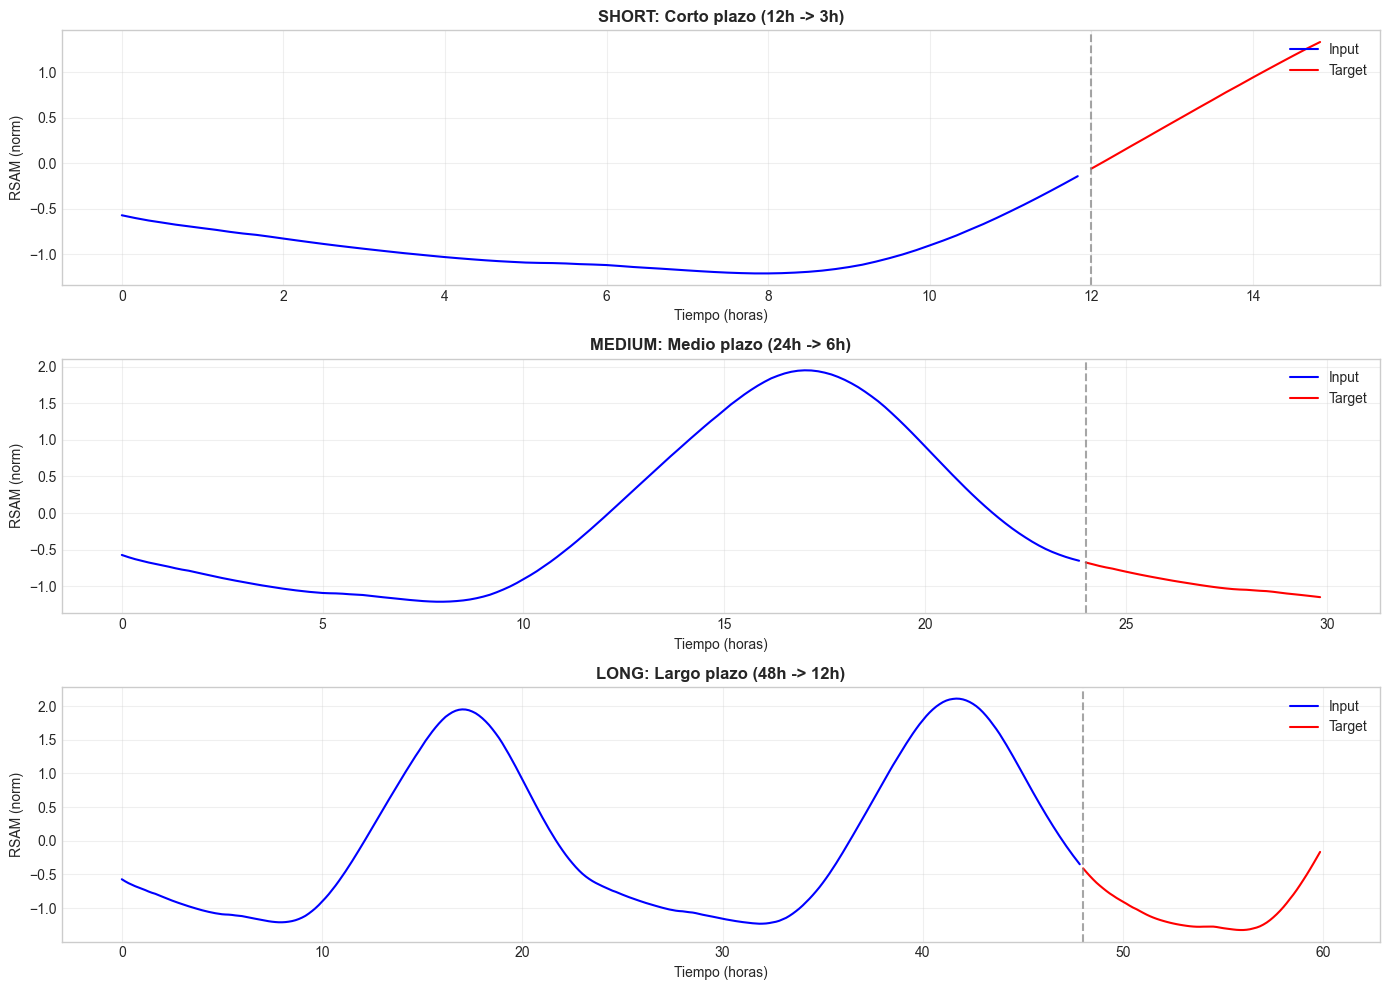

In [ ]:

fig, axes = plt.subplots(3, 1, figsize=(14, 10))
sample_idx = 100

for i, (config_name, data) in enumerate(datasets.items()):
    ax = axes[i]
    config = data['config']
    
    x_sample = data['X_train'][sample_idx, :, 0]
    y_sample = data['y_train'][sample_idx]
    
    t_input = np.arange(len(x_sample)) / RSAM_PER_HOUR
    t_output = np.arange(len(y_sample)) / RSAM_PER_HOUR + config['input_hours']
    
    ax.plot(t_input, x_sample, 'b-', linewidth=1.5, label='Input')
    ax.plot(t_output, y_sample, 'r-', linewidth=1.5, label='Target')
    ax.axvline(config['input_hours'], color='gray', linestyle='--', alpha=0.7)
    
    ax.set_title(f"{config_name.upper()}: {config['description']}", fontweight='bold')
    ax.set_xlabel('Tiempo (horas)')
    ax.set_ylabel('RSAM (norm)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'rsam_configuraciones_ventanas.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Guardar Datasets

In [ ]:
import json


df_rsam.to_csv(PROCESSED_DIR / 'rsam_series.csv', index=False)
print(f"Guardado: rsam_series.csv")


for config_name, data in datasets.items():
    config = data['config']
    
    
    np.savez_compressed(
        PROCESSED_DIR / f'rsam_{config_name}_seq2seq.npz',
        X_train=data['X_train'],
        X_val=data['X_val'],
        X_test=data['X_test'],
        y_train=data['y_train'],
        y_val=data['y_val'],
        y_test=data['y_test'],
        input_steps=config['input_steps'],
        output_steps=config['output_steps'],
        input_hours=config['input_hours'],
        output_hours=config['output_hours'],
        rsam_mean=rsam_mean,
        rsam_std=rsam_std
    )
    print(f"Guardado: rsam_{config_name}_seq2seq.npz")
    
    
    np.savez_compressed(
        PROCESSED_DIR / f'rsam_{config_name}_seq2one.npz',
        X_train=data['X_train'],
        X_val=data['X_val'],
        X_test=data['X_test'],
        y_train_mean=data['y_train_mean'],
        y_val_mean=data['y_val_mean'],
        y_test_mean=data['y_test_mean'],
        y_train_last=data['y_train_last'],
        y_val_last=data['y_val_last'],
        y_test_last=data['y_test_last'],
        input_steps=config['input_steps'],
        output_hours=config['output_hours'],
        rsam_mean=rsam_mean,
        rsam_std=rsam_std
    )
    print(f"Guardado: rsam_{config_name}_seq2one.npz")


metadata = {
    'station': STATION,
    'channel': CHANNEL,
    'years': YEARS,
    'sampling_rate': SAMPLING_RATE,
    'downsample_factor': DOWNSAMPLE_FACTOR,
    'rsam_window_seconds': RSAM_WINDOW_SECONDS,
    'rsam_per_hour': RSAM_PER_HOUR,
    'rsam_mean': float(rsam_mean),
    'rsam_std': float(rsam_std),
    'configurations': {
        name: {
            'input_hours': cfg['input_hours'],
            'output_hours': cfg['output_hours'],
            'input_steps': cfg['input_steps'],
            'output_steps': cfg['output_steps'],
            'n_train': len(datasets[name]['X_train']),
            'n_val': len(datasets[name]['X_val']),
            'n_test': len(datasets[name]['X_test'])
        }
        for name, cfg in WINDOW_CONFIGS.items()
    }
}

with open(PROCESSED_DIR / 'rsam_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Guardado: rsam_metadata.json")

Guardado: rsam_series.csv
Guardado: rsam_short_seq2seq.npz
Guardado: rsam_short_seq2one.npz
Guardado: rsam_medium_seq2seq.npz
Guardado: rsam_medium_seq2one.npz
Guardado: rsam_long_seq2seq.npz
Guardado: rsam_long_seq2one.npz
Guardado: rsam_metadata.json


In [14]:
print("\n" + "="*70)
print("RESUMEN FINAL")
print("="*70)

print(f"\nDatos: {STATION} {CHANNEL}, {YEARS}")
print(f"Frecuencia: {SAMPLING_RATE} Hz (decimado a {SAMPLING_RATE//DOWNSAMPLE_FACTOR} Hz)")
print(f"RSAM: {len(df_rsam):,} valores")

print(f"\nCONFIGURACIONES:")
print("-"*70)
print(f"{'Config':<10} {'Input':<12} {'Output':<12} {'Train':<10} {'Val':<10} {'Test':<10}")
print("-"*70)
for name, data in datasets.items():
    cfg = data['config']
    print(f"{name:<10} {cfg['input_hours']}h ({cfg['input_steps']} pts){'':<2} "
          f"{cfg['output_hours']}h ({cfg['output_steps']} pts){'':<2} "
          f"{len(data['X_train']):<10} {len(data['X_val']):<10} {len(data['X_test']):<10}")

print(f"\nARCHIVOS GENERADOS:")
print("  - rsam_series.csv")
print("  - rsam_short_seq2seq.npz / rsam_short_seq2one.npz")
print("  - rsam_medium_seq2seq.npz / rsam_medium_seq2one.npz")
print("  - rsam_long_seq2seq.npz / rsam_long_seq2one.npz")
print("  - rsam_metadata.json")

print(f"\nGuardados en: {PROCESSED_DIR.resolve()}")


RESUMEN FINAL

Datos: LC01 HHZ, [2023]
Frecuencia: 100 Hz (decimado a 20 Hz)
RSAM: 52,560 valores

CONFIGURACIONES:
----------------------------------------------------------------------
Config     Input        Output       Train      Val        Test      
----------------------------------------------------------------------
short      12h (72 pts)   3h (18 pts)   6122       1312       1312      
medium     24h (144 pts)   6h (36 pts)   6111       1310       1310      
long       48h (288 pts)   12h (72 pts)   6090       1305       1306      

ARCHIVOS GENERADOS:
  - rsam_series.csv
  - rsam_short_seq2seq.npz / rsam_short_seq2one.npz
  - rsam_medium_seq2seq.npz / rsam_medium_seq2one.npz
  - rsam_long_seq2seq.npz / rsam_long_seq2one.npz
  - rsam_metadata.json

Guardados en: C:\Users\nicol\Documents\AAST_PJ\AAST_PJ\data\processed
